# Running the EPSP analysis

## Step 1. Load the abf file and dependancies

In [31]:
#needed for array opening
import numpy as np
import matplotlib.pyplot as plt
import pyabf
import pandas as pd
import glob
#Scipy sub packages for some signal wrangling and stats
import scipy.signal as signal
from scipy.fftpack import fft, fftfreq
import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio
#NEO & elephant are packages for spike analysis and computing inst. freq.
import neo
import quantities as pq
from elephant import statistics
from elephant import kernels
#ipfx for detecting spikes
from ipfx.feature_extractor import SpikeFeatureExtractor
PA_SCALE = 1e-12
MV_SCALE = 1e-3
GOHM = 1000000000

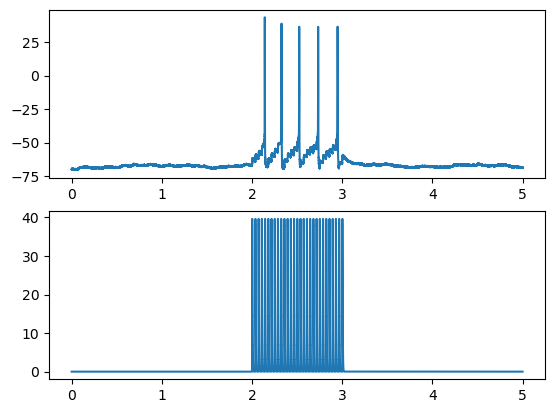

In [32]:

#load the demo_data
demo_data  = np.load(".\\data\\2021_09_23_0037.npz", allow_pickle=True)
f_x, f_y, f_c, stim_x, stim_y, stim_c = demo_data['f_x'], demo_data['f_y'], demo_data['f_c'], demo_data['stim_x'], demo_data['stim_y'], demo_data['stim_c']
#compute sample rate
sr = 1/(f_x[0,1] - f_x[0,0])
#plot them to see what they look like
plt.subplot(2,1,1)
plt.plot(f_x[-1], f_y[-1])
plt.subplot(2,1,2)
plt.plot(stim_x[-1], stim_y[-1])

## Step 2: Run QC and baseline the data
Now for each sweep check the variance during stim, and pre stim. Reject sweeps where variance prestim > variance post-stim. Also mask out spikes

(17, 100000)


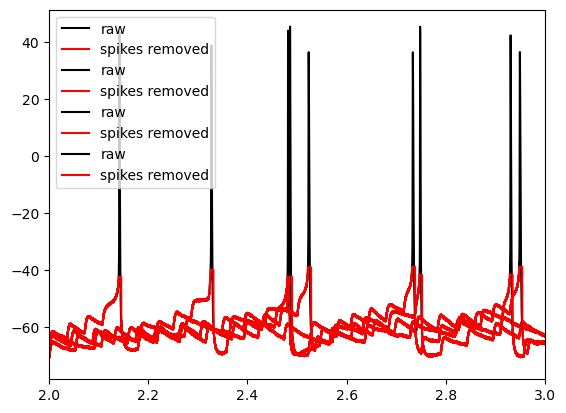

In [33]:
#find spikes
#using ipfx
sp = SpikeFeatureExtractor(dv_cutoff=20, min_peak=-5, filter=0) #using default values, min peak set high to make sure it does not over detect
print(f_y.shape)
for i in range(f_y.shape[0]):
    #extract the spikes
    features = sp.process(f_x[i], f_y[i], stim_y[i])
    #if there are spikes
    if features.empty==False:
        #get the idx of the threshold
        spike_times = np.array([np.argmin(np.abs(f_x[i] - x)) for x in features['threshold_t']])
        #get the trough idx
        trough_times = np.array([np.argmin(np.abs(f_x[i] - x)) for x in features['fast_trough_t']])
        #mask between the threshold and the trough using the point of the threshold
        plt.plot(f_x[i], f_y[i], color='black', label='raw')
        for j in range(len(spike_times)):
            #mask the spike, take 0.5ms before the threshold and 1ms after the trough
            f_y[i][spike_times[j]-int(0.0005*sr):trough_times[j]+int(0.001*sr)] = f_y[i, spike_times[j]-int(0.0005*sr)]
            
        #plot the sweep with the spikes
        plt.plot(f_x[i], f_y[i], c='r', label='spikes removed')
plt.xlim(2,3)
plt.legend()

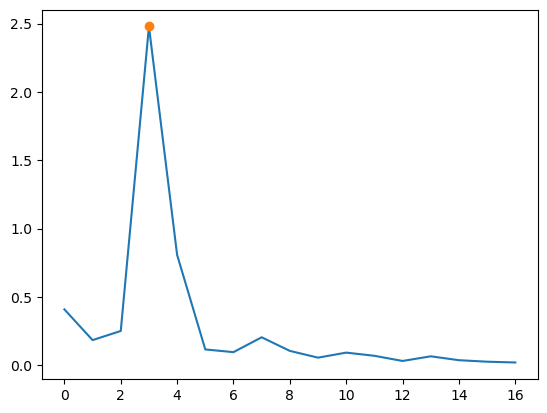

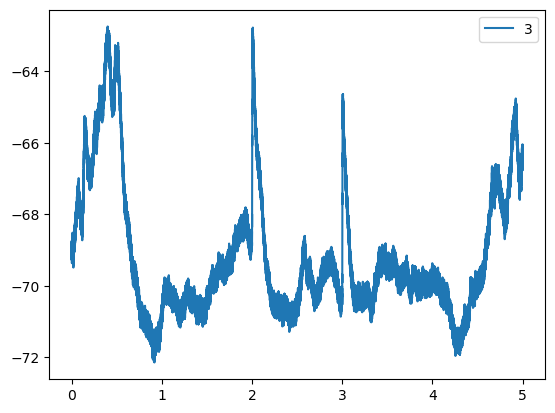

In [34]:
t0 = int(sr*2)
t1 = int(sr*3.5)
#compute the variance along the sweep axis
pre_stim_var = np.var(f_y[:,:t0], axis=1)
#compute the variance along the sweep axis
post_stim_var = np.var(f_y[:,t0:t1], axis=1)
#compute the ratio of the two
var_ratio = pre_stim_var/post_stim_var
#plot the ratio
plt.plot(var_ratio)
#plot the failed sweeps where the ratio is greater than 1
plt.plot(np.where(var_ratio > 1)[0], var_ratio[var_ratio > 1], 'o')
plt.figure()
for sweep in np.where(var_ratio > 1)[0]:
    plt.plot(f_x[sweep], f_y[sweep], label=sweep)
plt.legend()

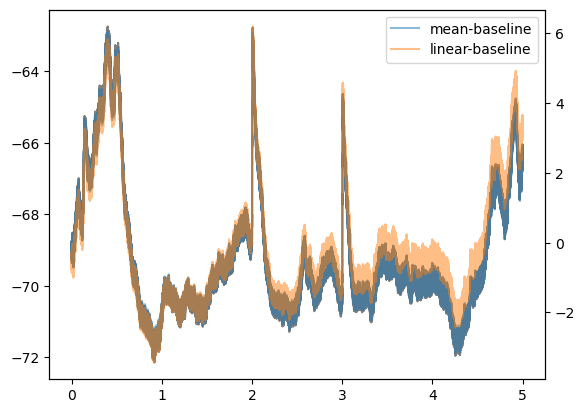

In [35]:
#now we two step baseline the data
plt.plot(f_x[3], f_y[3], label='raw', alpha=0.5, c='k') #plot the raw data
#first we subtract the mean of the first 2 seconds
fyb = f_y - np.nanmean(f_y[:, :t0], axis=1, keepdims=True) 
plt.twinx()
plt.plot(f_x[3], fyb[3], label='mean-baseline', alpha=0.5) #plot the mean baseline
#now we compute the linear regression for the sweep pre- and post-stim
#this move bias due to voltage drift'
#can be disabled in  code by setting lin_baseline arg to False
fy_lin = []
for step in np.arange(f_x.shape[0]): #for each sweep
    temp_fy_lin = stats.linregress(np.hstack((f_x[0,:t0], f_x[0,-t0:])), np.hstack((fyb[step,:t0], fyb[step,-t0:]))) #compute the linear regression
    fy_lin.append((temp_fy_lin.slope * f_x[step] + temp_fy_lin.intercept)) #remove the linear baseline
fy_lin = np.vstack(fy_lin) #stack the linear baseline vertically
fyb = fyb - fy_lin #subtract the linear baseline for each sweep
plt.plot(f_x[3], fyb[3], label='linear-baseline', alpha=0.5)
plt.legend()

## Step 3 (optional): compute the freq based imped. using FFT
Note that this analysis is not currently used but may be interesting
This is essentially the same concept as the chirp analysis. In essence following:
$$ V = IR $$
We can reformulate as
$$ R = V/I $$
from here we can compute the freq. dependence using the FFT transformation of V/I
$$ R = FFT(V)/FFT(I)

Text(0, 0.5, 'Impedence Response')

<Figure size 640x480 with 0 Axes>

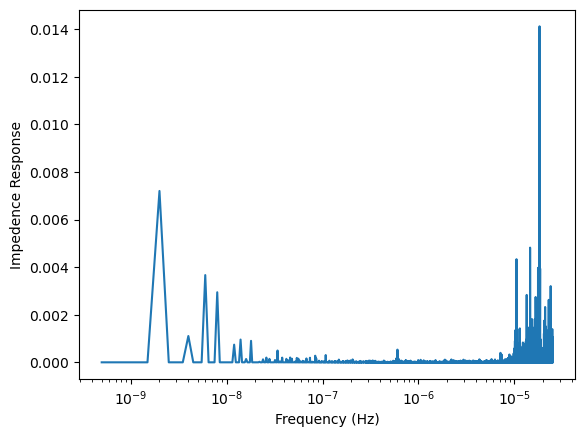

In [36]:
f_range = [0, 20] #cutoff frequency for the fft [lower, upper]
#compute the fft
fft_x = fftfreq(f_x.shape[1], sr) #compute the fft frequencies for the given sample rate

fft_y = fft(fyb * pq.mV, axis=1) #the fft of the voltage, we multiply by pq.mV to convert to volts
fft_c = fft(stim_y * pq.pA, axis=1) #the fft of the current, we multiply by pq.pA to convert to amps

#drop the negative frequencies, and the frequencies above the cutoff
fft_y = fft_y[:, fft_x > 0]
fft_c = fft_c[:, fft_x > 0]
fft_x = fft_x[fft_x > 0]
fft_y = fft_y[:, fft_x < f_range[1]]
fft_c = fft_c[:, fft_x < f_range[1]]
fft_x = fft_x[fft_x < f_range[1]]

#compute the power spectrum
impedence_response = np.abs(fft_y / fft_c) / 1000000000 #convert to GOhm
plt.clf()
plt.figure(num=90)
plt.plot(fft_x, np.mean(impedence_response, axis=0))
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedence Response')

## Step 4: Compute the metrics on a per sweep basis
Now we will compute some metrics (E.g voltage response) that are computed on a per sweep basis. For this example I will compute the metrics for sweep 5

### Sub step 1: find the peaks in the stim

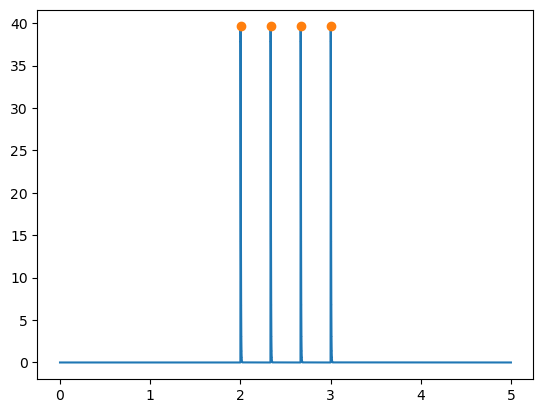

In [37]:
sweep = 5

#find the peaks using scipy
peaks = signal.find_peaks(stim_y[sweep],width=int(sr*0.001), height=8) #here we are looking for the peaks of the epsp of the stim
#plot the peaks
plt.plot(stim_x[sweep], stim_y[sweep]) #plot the stim
plt.plot(stim_x[sweep][peaks[0]], stim_y[sweep][peaks[0]], 'o') #plot the peaks
#now we can compute the sweepwise freq
sweepwise_hz = len(peaks[0])/1 #number of peaks over time (1 second)
#now we can compute the mean freq


### Sub Step 2: Compute the instantaneous rate


(0.0, 5.0)

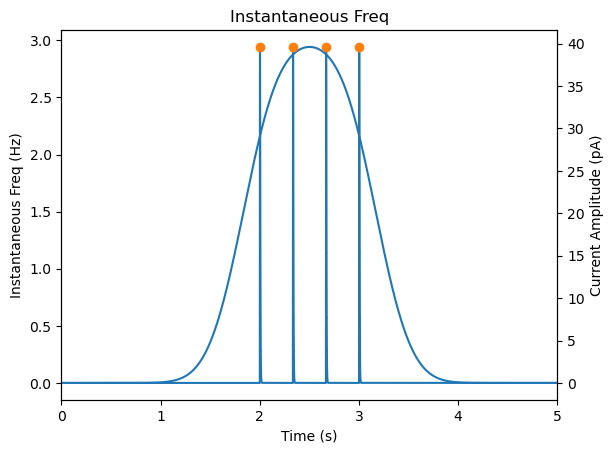

In [38]:
#now we can compute the instantaneous freq across the sweep. To do so we will use the elephant ephys package
#first we need to convert the stim to a neo analogsignal
spike_times = stim_x[sweep,peaks[0]] #get the spike times
spike_train = neo.SpikeTrain(spike_times, t_stop=13*pq.s, units=pq.s) #convert to a spike train
kernel = kernels.GaussianKernel(sigma=300 * pq.ms) #define the kernel
i_r = np.hstack(statistics.instantaneous_rate(spike_train, (1/sr)*pq.s, kernel=kernel)[:,0].tolist()) #compute the instantaneous rate

#plot the instantaneous rate
plt.figure()
plt.plot(np.linspace(0, 13, i_r.shape[0]), i_r)
plt.xlabel('Time (s)')
plt.ylabel('Instantaneous Freq (Hz)')
plt.title('Instantaneous Freq')
plt.twinx()
plt.plot(stim_x[sweep], stim_y[sweep]) #plot the stim
plt.plot(stim_x[sweep][peaks[0]], stim_y[sweep][peaks[0]], 'o') #plot the peaks
plt.ylabel("Current Amplitude (pA)")
plt.xlim(0,5)

### Sub Step 3: Compute the mean response and peak response
Using our overall freq and the instantaneous freq we can compute the mean response and peak response. 
In short: 
Mean response is the mean non-zero voltage response of the sweep.

The peak response is the mean voltage at each stim peak time. However this estimates lower than expect as it takes a hot minute for the cell to catch up with the stim. So we actually look for the max within 10ms of the stim peak

Currently only mean response is used in analysis

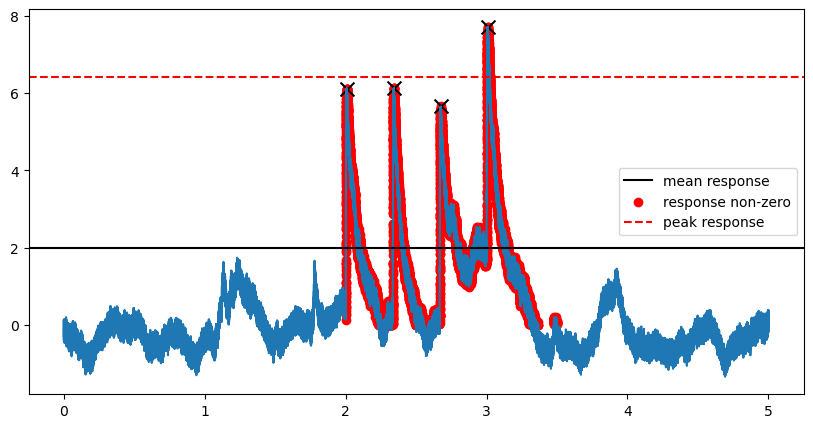

In [39]:
#Compute the mean response across the sweep
mean_response = np.mean(fyb[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)], axis=0)
#plot the mean response
plt.figure(figsize=(10, 5))
plt.plot(f_x[sweep], fyb[sweep])
plt.axhline(np.mean(fyb[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)]), c='k', label='mean response')
plt.scatter(f_x[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)], fyb[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)], c='r', label='response non-zero')


#now compute the peak response
peak_response = []
for peak in peaks[0]: #for each peak
    #we want to take the max of the 10ms before and after the peak
    peak_response.append(np.nanmax(fyb[sweep, peak-int(sr*0.01):peak+int(sr*0.01)]))
    #plot the detected peak
    idx_peak = np.argmax(fyb[sweep, peak-int(sr*0.01):peak+int(sr*0.01)]) + peak-int(sr*0.01)
    plt.scatter(f_x[sweep,idx_peak], fyb[sweep,idx_peak], c='k', marker='x', s=100)
peak_response = np.mean(peak_response) #compute the mean peak response
plt.axhline(peak_response, c='r', ls='--', label='peak response')
plt.legend()

### Sub Step 3-2: Compute the AUC for the upwards swings



In [40]:
#compute the AUC of the postive response
np.trapz(fyb[sweep, (fyb[sweep, :]>=0)], f_x[sweep, (fyb[sweep, :]>=0)])

2.973238647332778

### Sub Step 4: compute the inst. voltage response to the inst. freq
For this metric, we sub divde the sweep into 10 bins (500ms bins). We then compute the mean inst. freq. and mean voltage response for each bin.
This metric is bad and is currently not used in any figures. I think I should adjust the bin number.
Note this is quite time consuming, so we can disable it by setting the keyword compute_inst_freq to false

C:\Users\SMest\AppData\Local\Temp\ipykernel_6916\2137672829.py:9: RuntimeWarning: Mean of empty slice
  f_resp.append(np.nanmean(fyb[sweep, idx_to_use][fyb[sweep, idx_to_use]>0])) #compute the mean response in this bin


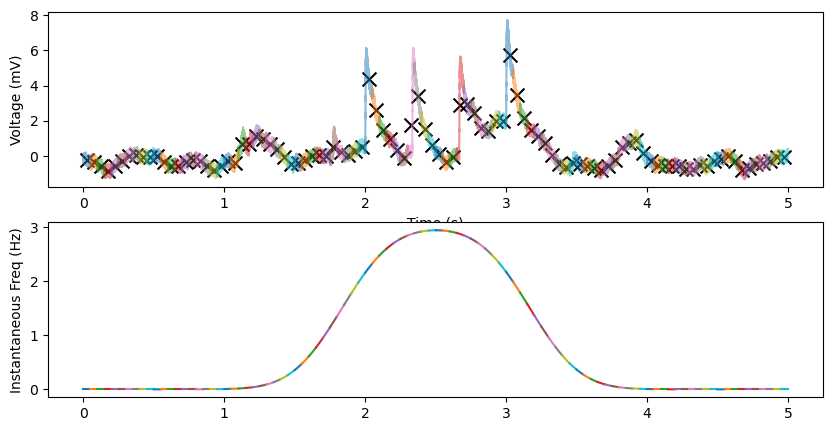

In [41]:
time_ind = np.arange(stim_x.shape[1]) #create an array of time indices
binned_t = np.split(time_ind, 100) #split the time indices into 100 bins

f_resp = [] #the mean response in each bin
f_stim = [] #the mean stim in each bin
plt.figure(figsize=(10, 5))
for bin in binned_t: #for each bin
    idx_to_use = bin #the indices to use for this bin
    f_resp.append(np.nanmean(fyb[sweep, idx_to_use][fyb[sweep, idx_to_use]>0])) #compute the mean response in this bin
    f_stim.append(np.nanmean(i_r[idx_to_use])) #compute the mean stim in this bin
    #plot the bin
    plt.subplot(2,1,1)
    plt.scatter(np.nanmean(f_x[sweep, idx_to_use]), np.nanmean(fyb[sweep, idx_to_use]), c='k', marker='x', s=100)
    plt.plot(f_x[sweep, idx_to_use], fyb[sweep, idx_to_use], alpha=0.5)
    plt.ylabel('Voltage (mV)')
    plt.xlabel('Time (s)')
    plt.subplot(2,1,2)
    plt.plot(np.linspace(0, 13, i_r.shape[0])[idx_to_use], i_r[idx_to_use])
    plt.ylabel('Instantaneous Freq (Hz)')
f_resp = np.array(f_resp) #convert to array


### Sub Step 5: Compute the offset decay time constant
Finally, we will compute the offset decay time constant. To do so, we will fit an exponential decay:
$$ y = a * exp(-tau * t) + c $$
 to the final stim pulse in the sweep.
We will use the scipy.optimize.curve_fit function to do so.

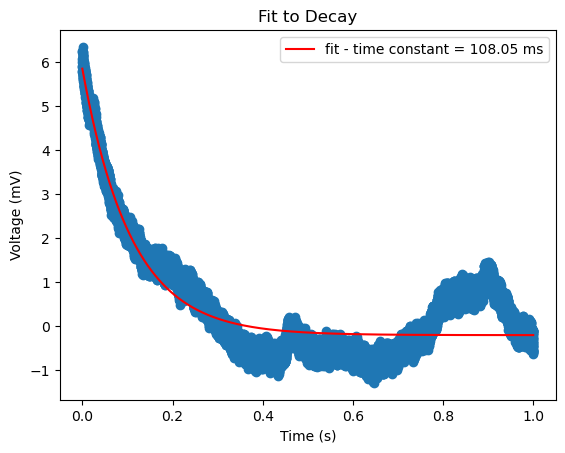

In [42]:

def exp_decay(t, a, tau, c): #decay function
    return a * np.exp(-tau * t) + c

#find the last point of nonzero in stim y
last_point = np.where(stim_y[sweep]>0)[0][-1]
#take 1 s after the last point
data = fyb[sweep][last_point:last_point+int(sr*1)]
#curve fit to the last 1 second
out = curve_fit(exp_decay, stim_x[0][last_point:last_point+int(sr*1)] - stim_x[0][last_point], fyb[sweep][last_point:last_point+int(sr*1)],
bounds=([0, 0.0, -np.inf], [9, np.inf, np.inf]), p0=[3, 0.5, 0], maxfev=10000)
#our return time constant is in units of 1/s, so convert to ms
tau = 1/out[0][1] * 1000
#plot the fit
plt.figure()
plt.plot(stim_x[0][last_point:last_point+int(sr*1)] - stim_x[0][last_point], fyb[sweep][last_point:last_point+int(sr*1)], 'o')
plt.plot(stim_x[0][last_point:last_point+int(sr*1)] - stim_x[0][last_point], exp_decay(stim_x[0][last_point:last_point+int(sr*1)] - stim_x[0][last_point], *out[0]), 'r-', label=f'fit - time constant = {tau:.2f} ms')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Fit to Decay')
plt.legend()

The above analysis is repeated for each sweep. 

## Step 5 (optional): Run some final statistics
For the inst. freq. analysis we end up with a lot of overlapping frequncies across sweeps. Eg. Sweep 5, 6, 7, all have periods of 2Hz inst. freq. To fix this, we will bin the analyzed frequncies and compute the mean response for each freq. across all sweeps. 
Note since we dont use this data in analysis, this part is option.

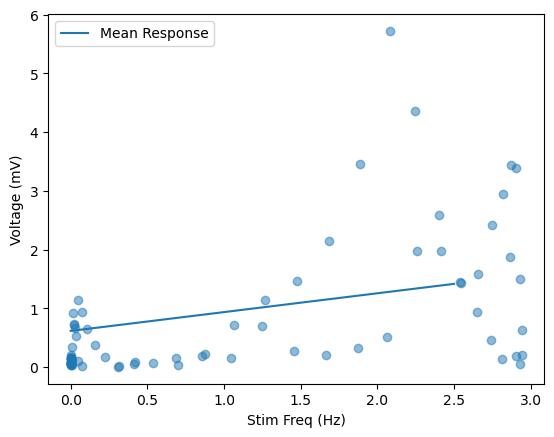

In [43]:
#create bins for the frequency. Ranging from 0 to 30 Hz in 2.5 Hz bins
bins_in = np.arange(0, 30, 2.5)
#bin the stim freq into the bins
hist, bins = np.histogram(f_stim, bins_in) 
#also compute the indices that each stim freq falls into
indices = np.digitize(f_stim, bins, right=True)
#now we want to step through each indice and compute the mean response.
#  Each index corresponds to a bin
uni = np.unique(indices)

bins_in = np.hstack((0, bins_in, 30)) #since we have 12 bins, we need 13 bin edges
x_data =  bins_in[uni] #for plotting, we want the bin edges
f_resp_mean = [] #the mean response in each bin
for val in np.unique(indices): #for each bin
    idx_to_use = np.ravel(np.argwhere(indices==val)) #the indices to use for this bin
    f_resp_mean.append(np.nanmean(f_resp[idx_to_use][f_resp[idx_to_use]>0])) #compute the mean response in this bin, take greater than 0 
#plot the full response in each bin
plt.scatter(f_stim, f_resp, alpha=0.5)
plt.plot(x_data, f_resp_mean, label='Mean Response')
plt.xlabel('Stim Freq (Hz)')
plt.ylabel('Voltage (mV)')
plt.legend()


Since this is only for one sweep. The result is not spectacular. 

## Step 6: Putting it all together for batch analysis
The above analysis is all gathered under one function called run analysis

In [44]:
PA_SCALE = 1e-12
MV_SCALE = 1e-3
GOHM = 1000000000
def compute_impedence_freq(x, y, c, f_range, f_step=100, plot=False):
    

    dt = x[0, 1] - x[0,0]
    f_x = fftfreq(x.shape[1], dt)
    f_y = fft(y * pq.mV, axis=1)
    f_c = fft(c * pq.pA, axis=1)
    f_y = f_y[:, f_x > 0]
    f_c = f_c[:, f_x > 0]
    f_x = f_x[f_x > 0]

    f_y = f_y[:, f_x < f_range[1]]
    f_c = f_c[:, f_x < f_range[1]]
    f_x = f_x[f_x < f_range[1]]

    N =  len(f_y)
    impedence_response = np.abs(f_y / f_c) / GOHM
    if plot:
        plt.clf()
        plt.figure(num=90)
        plt.plot(f_x, np.mean(impedence_response, axis=0))
        plt.xscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Impedence Response')
        plt.pause(5)
    return f_x, impedence_response


def exp_decay(t, a, tau, c):
    return a * np.exp(-tau * t) + c


def run_analysis(abf, stim_abf, line_baseline=True, compute_inst_freq=True, mask_spikes=True, plot=False):
    """Run EPSP analysis over 

    Args:
        abf (str or path): the path to the response abf file
        stim_abf (_type_): the path to the stimulus abf file
        line_baseline (bool, optional): Applies linear regression to baseline the sweep,
                                        accounting for voltage drift. Defaults to True.
        compute_inst_freq (bool, optional): Compute the inst. freq. response for each sweep. 
                                            Takes a long time and can be disabled. Defaults to True.
        mask_spikes (bool, optional): Masks the spikes in the response. Defaults to True.
        plot (bool, optional): plot the gathered data. Defaults to False.

    Returns:
        dict: containing the resp means and FFT data
    

    """
    #Load the EPSP DATA
    f_x, f_y, f_c = loadABF(abf)
    stim_x, stim_y, stim_c = loadABF(stim_abf)

    #apply scaling
    sr = int(1/(f_x[0,1]-f_x[0, 0]))




    #Baseline the data
    t0 = int(sr * 2)
    t1 = int(sr * 3.5)
    #compute the variance along the sweep axis
    pre_stim_var = np.var(f_y[:,:t0], axis=1)
    #compute the variance along the sweep axis
    post_stim_var = np.var(f_y[:,t0:t1], axis=1)
    #compute the ratio of the two
    var_ratio = pre_stim_var/post_stim_var

    #mask the sweeps that have a variance ratio greater than 1.5
    mask = var_ratio > 1.5
    #apply the mask to the data
    f_y[mask, :] = 0

    if mask_spikes:
        #find spikes
        #using ipfx
        sp = SpikeFeatureExtractor(dv_cutoff=20, min_peak=-5, filter=0) #using default values, min peak set high to make sure it does not over detect
        for i in range(f_y.shape[0]):
            #extract the spikes
            features = sp.process(f_x[i], f_y[i], stim_y[i])
            #if there are spikes
            if features.empty==False:
                #get the idx of the threshold
                spike_times = np.array([np.argmin(np.abs(f_x[i] - x)) for x in features['threshold_t']])
                #get the trough idx
                trough_times = np.array([np.argmin(np.abs(f_x[i] - x)) for x in features['fast_trough_t']])
                #mask between the threshold and the trough using the point of the threshold
                plt.plot(f_x[i], f_y[i], color='black', label='raw')
                for j in range(len(spike_times)):
                    #mask the spike, take 0.5ms before the threshold and 1ms after the trough
                    f_y[i][spike_times[j]-int(0.0005*sr):trough_times[j]+int(0.001*sr)] = f_y[i, spike_times[j]-int(0.0005*sr)]


    #baseline using the mean
    fyb = f_y - np.nanmean(f_y[:, :t0], axis=1, keepdims=True)
    if line_baseline: # if the user wants to baseline the data with a linear regression
        fy_lin = [] #create an empty list to store the baseline corrected data
        for step in np.arange(f_x.shape[0]): #loop through the sweeps
            temp_fy_lin = stats.linregress(np.hstack((f_x[0,:t0], f_x[0,-t0:])), np.hstack((fyb[step,:t0], fyb[step,-t0:])))
            fy_lin.append((temp_fy_lin.slope * f_x[step] + temp_fy_lin.intercept)) #append the baseline corrected data to the list
        fy_lin = np.vstack(fy_lin) #convert the list to a numpy array
        fyb = fyb - fy_lin #subtract the linear baseline from the data


    #compute the freq-dependent impedence response
    fft_x,fft_resp = compute_impedence_freq(f_x, fyb, stim_y, [0, 20], f_step=100)


    #now we are going to step through the sweeps and compute some metrics
    # gonna create a million lists to store the data, cause im lazy
    f_stim = [] #list to store the stimulus frequency
    pointwise_diff = [] #list to store the pointwise difference between the stimulus and the response, UNUSED, only for paired data
    stim_amp = [] #//UNUSED FOR NOW// list to store the stimulus amplitude
    time_ind = np.arange(stim_x.shape[1]) #create an array of time indices
    binned_t = np.split(time_ind, 10) #split the time indices into 10 bins
    sweepwise_hz = [] #The overall stim freq per sweep
    f_sweepwise_resp = [] #The overall response per sweep
    f_resp = [] #The overall inst. freq. response
    sweep_wise_offset = [] #The overall offset per sweep
    sweep_wise_offset_params = [] #The overall offset params per sweep
    sweep_wise_peak_mean = [] #The overall peak mean per sweep
    sweep_wise_auc = [] #The overall area under the curve per sweep
    for sweep in np.arange(f_x.shape[0]):
        #compute the stimulus frequency
        peaks = signal.find_peaks(stim_y[sweep],width=int(sr*0.001), height=8) #find the peaks in the stimulus

        #compute the mean response
        sweepwise_hz.append(len(peaks[0])/1) #compute the frequency of the stimulus
        f_sweepwise_resp.append(np.nanmean(fyb[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)])) #compute the mean of the response

        #compute the AUC of the postive response
        sweep_wise_auc.append(np.trapz(fyb[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)], f_x[sweep, t0:t1][(fyb[sweep, t0:t1]>=0)]))

        #now compute the peak response
        peak_response = []
        for peak in peaks[0]: #for each peak
            #we want to take the max of the 10ms before and after the peak
            peak_response.append(np.nanmax(fyb[sweep, peak-int(sr*0.01):peak+int(sr*0.01)]))
        sweep_wise_peak_mean.append(np.mean(peak_response)) #compute the mean peak response


        #compute the inst. freq. of the sweep by using elephant
        if compute_inst_freq: #if the user wants to compute the inst. freq.
            spike_times = stim_x[sweep,peaks[0]] #Pull the spike times
            spike_train = neo.SpikeTrain(spike_times, t_stop=13*pq.s, units=pq.s) #turn the epsp incoming into a spike train, t_stop is meaning less
            kernel = kernels.GaussianKernel(sigma=300 * pq.ms) #create a gaussian kernel
            i_r = np.hstack(statistics.instantaneous_rate(spike_train, (1/sr)*pq.s, kernel=kernel)[:,0].tolist()) #compute the inst. freq. of the sweep
            for bin in binned_t:
                idx_to_use = bin
                f_resp.append(np.nanmean(fyb[sweep, idx_to_use]))
                f_stim.append(np.nanmean(i_r[idx_to_use]))
        else:
            #if the user disables the inst. freq. we need to fill the means with zeros so the data is the same shape
            f_stim.append(0)
            f_resp.append(0)
            

        #Now fitting the exp decay
        #find the last point of nonzero in stim y
        last_point = np.where(stim_y[sweep]>0)[0][-1]
        #take 500ms after the last point
        sweep_wise_offset.append(fyb[sweep][last_point:last_point+int(sr*1)])
        #curve fit to the last 1second
        out = curve_fit(exp_decay, stim_x[0][last_point:last_point+int(sr*1)] - stim_x[0][last_point], fyb[sweep][last_point:last_point+int(sr*1)],
        bounds=([0, 0.0, -np.inf], [9, np.inf, np.inf]), p0=[3, 0.5, 0], maxfev=10000)
        sweep_wise_offset_params.append(out[0]) #store the params
        
    
    
    #compute means
    f_resp = np.array(f_resp)
    
    f_resp_mean = []
    bins_in = np.arange(0, 30, 2.5)
    hist, bins = np.histogram(f_stim, bins_in)
    indices = np.digitize(f_stim, bins, right=True)
    uni = np.unique(indices)
    bins_in = np.hstack((0, bins_in, 30))
    x_data =  bins_in[uni]
    sweep_wise_offset_params =  np.array(sweep_wise_offset_params)
    for val in np.unique(indices):
        idx_to_use = np.ravel(np.argwhere(indices==val))
        f_resp_mean.append(np.nanmean(f_resp[idx_to_use]))

    
    if plot:
        plt.clf()
        plt.figure()
        plt.scatter(f_stim, f_resp, alpha=0.1)
        plt.plot(x_data, f_resp_mean)
        plt.ylabel("voltage resp amplitude (mV)")
        plt.xlabel("input freq")
        plt.legend()
        plt.pause(10)

    #return the results as a dict for easy usage
    dict_return = {"f_stim":f_stim, #the inst. freq. of the stimulus
    "f_resp":f_resp, #the inst. freq. of the response
    "f_resp_mean":f_resp_mean, #the mean inst. freq. of the response
    "x_data":x_data,  #the x data for the mean
    "sweep_wise_offset":sweep_wise_offset,  #the offset of the response
    "sweep_wise_offset_params": np.ravel(sweep_wise_offset_params),  #the offset params of the response
    "sweepwise_hz":sweepwise_hz, #the overall stim freq per sweep
    "f_sweepwise_resp":f_sweepwise_resp,  #the overall response per sweep
    "fft_x":fft_x, #the fft x data
    "fft_resp":fft_resp,#the fft response
    "sweepwise_peak_mean": sweep_wise_peak_mean,
    'sweepwise_auc':sweep_wise_auc} 
    return dict_return

Now we can have the script iterate through each file. Running the function and concatenating results

In [45]:
#pass the data to the function
dict_return = run_analysis(abf, stim_abf)
#its returned as a dict so you can easily access the data, each key is the numpy array representing the data
[print(key, dict_return[key]) for key in dict_return.keys()]

NameError: name 'abf' is not defined